In [31]:
pip install bayesian-optimization

# **1. Data Loading and Initial Preprocessing**

In [32]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('Jakarta_Rainfall_Dataset.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

print("Initial DataFrame Info:")
df.info()

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3288 entries, 01-01-2016 to 31-12-2024
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   min_temperature      3208 non-null   float64
 1   max_temperature      3265 non-null   float64
 2   avg_temperature      3278 non-null   float64
 3   avg_humidity         3282 non-null   float64
 4   rainfall             2631 non-null   float64
 5   sunshine_duration    3227 non-null   float64
 6   max_wind_speed       3288 non-null   int64  
 7   wind_direction       3288 non-null   int64  
 8   avg_wind_speed       3288 non-null   int64  
 9   most_wind_direction  3288 non-null   object 
dtypes: float64(6), int64(3), object(1)
memory usage: 282.6+ KB


In [33]:
# Check the percentage of missing values in each column
print("Missing values percentage before dropping NaNs:")
print(df.isnull().mean() * 100)

Missing values percentage before dropping NaNs:
min_temperature         2.433090
max_temperature         0.699513
avg_temperature         0.304136
avg_humidity            0.182482
rainfall               19.981752
sunshine_duration       1.855231
max_wind_speed          0.000000
wind_direction          0.000000
avg_wind_speed          0.000000
most_wind_direction     0.000000
dtype: float64


In [34]:
# Handle missing categorical data (most_wind_direction)
if df['most_wind_direction'].isnull().any():
    print("Imputing missing 'most_wind_direction' with mode...")
    mode_wind_direction = df['most_wind_direction'].mode()[0]
    df['most_wind_direction'].fillna(mode_wind_direction, inplace=True)
    print(f"'most_wind_direction' NaNs after mode imputation: {df['most_wind_direction'].isnull().sum()}")

In [35]:
# Drop rows where 'rainfall' (target variable) is NaN
# It's crucial not to impute the target variable for training
initial_rows = df.shape[0]
df.dropna(subset=['rainfall'], inplace=True)
print(f"Removed {initial_rows - df.shape[0]} rows due to missing 'rainfall' values.")

Removed 657 rows due to missing 'rainfall' values.


### Apply KNNImputer for numerical columns



In [36]:
from sklearn.impute import KNNImputer

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Exclude 'rainfall' from imputation as it's already dropped for NaNs
if 'rainfall' in numerical_cols:
    numerical_cols.remove('rainfall')

# Print only columns that still have NaNs in the selected numerical columns
print("Missing numerical values before KNNImputation:")
missing_before_imputation = df[numerical_cols].isnull().sum()
print(missing_before_imputation[missing_before_imputation > 0])


if numerical_cols: # Only proceed if there are numerical columns to impute
    imputer = KNNImputer(n_neighbors=5)
    # Perform imputation on a temporary DataFrame containing only the numerical columns for efficiency
    temp_df_numerical = df[numerical_cols]
    df[numerical_cols] = imputer.fit_transform(temp_df_numerical)

print("\nMissing numerical values after KNNImputation:")
missing_after_imputation = df[numerical_cols].isnull().sum()
print(missing_after_imputation[missing_after_imputation > 0]) # Should be all zeros now

print(f"\nDataFrame shape after imputation: {df.shape}")

Missing numerical values before KNNImputation:
min_temperature      44
max_temperature      18
avg_temperature       6
avg_humidity          3
sunshine_duration    50
dtype: int64

Missing numerical values after KNNImputation:
Series([], dtype: int64)

DataFrame shape after imputation: (2631, 10)


# **2. Feature Engineering**

In [37]:
# Create new features
df['temp_humidity_interaction'] = df['avg_temperature'] * df['avg_humidity']
df['rainfall_per_sunshine'] = df.apply( # Set to 0 if sunshine_duration is 0, otherwise calculate the ratio
    lambda row: row['rainfall'] / row['sunshine_duration'] if row['sunshine_duration'] != 0 else 0,
    axis=1
)

In [38]:
# Add rolling statistics for 'rainfall' and 'avg_temperature'
for window in [3, 7, 14]:
    df[f'rainfall_rolling_mean_{window}d'] = df['rainfall'].rolling(window=window).mean()
    df[f'rainfall_rolling_std_{window}d'] = df['rainfall'].rolling(window=window).std()
    df[f'temp_rolling_mean_{window}d'] = df['avg_temperature'].rolling(window=window).mean()
    df[f'temp_rolling_std_{window}d'] = df['avg_temperature'].rolling(window=window).std()

In [39]:
# Add seasonal decomposition features
from statsmodels.tsa.seasonal import seasonal_decompose
try:
    # Ensure no NaNs before seasonal decomposition that would cause it to fail
    temp_series = df['rainfall'].dropna()
    if not temp_series.empty:
        print("Creating seasonal decomposition features...")
        seasonal_decomp = seasonal_decompose(temp_series, period=365, extrapolate_trend='freq')
        # Reindex the decomposed components to match the original DataFrame's index
        df['trend'] = seasonal_decomp.trend.reindex(df.index)
        df['seasonal'] = seasonal_decomp.seasonal.reindex(df.index)
        df['residual'] = seasonal_decomp.resid.reindex(df.index)
        print("Seasonal decomposition features created successfully.")
    else:
        print("Rainfall series is empty after dropping NaNs for seasonal decomposition. Skipping.")
        df['trend'] = np.nan
        df['seasonal'] = np.nan
        df['residual'] = np.nan
except Exception as e:
    print(f"Seasonal decomposition failed: {e}. Skipping this feature.")
    df['trend'] = np.nan
    df['seasonal'] = np.nan
    df['residual'] = np.nan

Creating seasonal decomposition features...
Seasonal decomposition features created successfully.


In [40]:
# Drop NaNs introduced by rolling windows and seasonal decomposition
# This dropna is fine as it's after imputation and targets are already clean.
df.dropna(inplace=True)
print(f"DataFrame shape after feature engineering NaNs: {df.shape}")

DataFrame shape after feature engineering NaNs: (2618, 27)


# **3. Outlier Removal (using IQR, applied sequentially to each numeric column)**

In [41]:
outlier_log = {}
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    before = len(df)
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    after = len(df)
    outlier_log[col] = before - after

print("Outlier removal summary (rows removed by column):")
for k, v in outlier_log.items():
    if v > 0:
        print(f"  {k}: {v} rows")
print(f"\nDataFrame shape after outlier removal: {df.shape}")

Outlier removal summary (rows removed by column):
  max_temperature: 50 rows
  avg_temperature: 7 rows
  avg_humidity: 14 rows
  rainfall: 399 rows
  max_wind_speed: 252 rows
  avg_wind_speed: 3 rows
  temp_humidity_interaction: 43 rows
  rainfall_per_sunshine: 362 rows
  rainfall_rolling_mean_3d: 158 rows
  rainfall_rolling_std_3d: 156 rows
  temp_rolling_mean_3d: 21 rows
  temp_rolling_std_3d: 34 rows
  rainfall_rolling_mean_7d: 59 rows
  rainfall_rolling_std_7d: 46 rows
  temp_rolling_mean_7d: 12 rows
  temp_rolling_std_7d: 28 rows
  rainfall_rolling_mean_14d: 24 rows
  rainfall_rolling_std_14d: 13 rows
  temp_rolling_mean_14d: 1 rows
  temp_rolling_std_14d: 16 rows
  trend: 15 rows
  seasonal: 37 rows
  residual: 7 rows

DataFrame shape after outlier removal: (861, 27)


# **4. Time-based and Categorical Features**

In [42]:
# Ensure the index is a DatetimeIndex before creating cyclical features
if not isinstance(df.index, pd.DatetimeIndex):
    print("Converting index to DatetimeIndex...")
    df.index = pd.to_datetime(df.index)
    print("Index converted successfully.")

Converting index to DatetimeIndex...
Index converted successfully.


<ipython-input-42-119592976>:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index)


In [43]:
# Create cyclical time features
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.0)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.0)
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12.0)
df['weekday_sin'] = np.sin(2 * np.pi * df.index.weekday / 7.0)
df['weekday_cos'] = np.cos(2 * np.pi * df.index.weekday / 7.0)


# Create lag features for 'rainfall' (target variable)
for lag in [1, 2, 3, 6, 12, 24, 365]:
    df[f'rainfall_lag_{lag}'] = df['rainfall'].shift(lag)

# Add lag features for 'avg_temperature' and 'avg_humidity'
for lag in [1, 3, 7]:
    df[f'avg_temperature_lag_{lag}'] = df['avg_temperature'].shift(lag)
    df[f'avg_humidity_lag_{lag}'] = df['avg_humidity'].shift(lag)

df.dropna(inplace=True) # Drop NaNs introduced by lag features
print(f"DataFrame shape after lag feature engineering: {df.shape}")

DataFrame shape after lag feature engineering: (496, 46)


In [44]:
# Apply one-hot encoding to 'most_wind_direction'
df = pd.get_dummies(df, columns=['most_wind_direction'], prefix='wind_dir', dummy_na=False)
print("DataFrame Info after one-hot encoding:")
df.info()

DataFrame Info after one-hot encoding:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2018-10-11 to 2024-12-15
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   min_temperature            496 non-null    float64
 1   max_temperature            496 non-null    float64
 2   avg_temperature            496 non-null    float64
 3   avg_humidity               496 non-null    float64
 4   rainfall                   496 non-null    float64
 5   sunshine_duration          496 non-null    float64
 6   max_wind_speed             496 non-null    float64
 7   wind_direction             496 non-null    float64
 8   avg_wind_speed             496 non-null    float64
 9   temp_humidity_interaction  496 non-null    float64
 10  rainfall_per_sunshine      496 non-null    float64
 11  rainfall_rolling_mean_3d   496 non-null    float64
 12  rainfall_rolling_std_3d    496 non-null    float

# **5. Feature Selection (Mutual Information)**

In [45]:
from sklearn.feature_selection import mutual_info_regression

X = df.drop(columns=['rainfall'])
y = df['rainfall']

# Convert boolean columns to integer for mutual_info_regression
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

mi = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Select top 20 features
selected_features = mi_scores.head(20).index.tolist()

X = df[selected_features]
print(f"Selected {len(selected_features)} features based on Mutual Information:")
X.info()

Selected 20 features based on Mutual Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2018-10-11 to 2024-12-15
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rainfall_per_sunshine      496 non-null    float64
 1   rainfall_rolling_std_3d    496 non-null    float64
 2   rainfall_rolling_mean_3d   496 non-null    float64
 3   rainfall_rolling_std_7d    496 non-null    float64
 4   temp_humidity_interaction  496 non-null    float64
 5   rainfall_rolling_mean_7d   496 non-null    float64
 6   wind_dir_NW                496 non-null    bool   
 7   avg_humidity_lag_1         496 non-null    float64
 8   rainfall_lag_3             496 non-null    float64
 9   rainfall_lag_12            496 non-null    float64
 10  avg_humidity               496 non-null    float64
 11  rainfall_lag_6             496 non-null    float64
 12  rainfall_rolling_std_14d   496 non-nu

# **6. Data Scaling**

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled is a now numpy array now, not a DataFrame.

# **7. Plotting Selected Features**

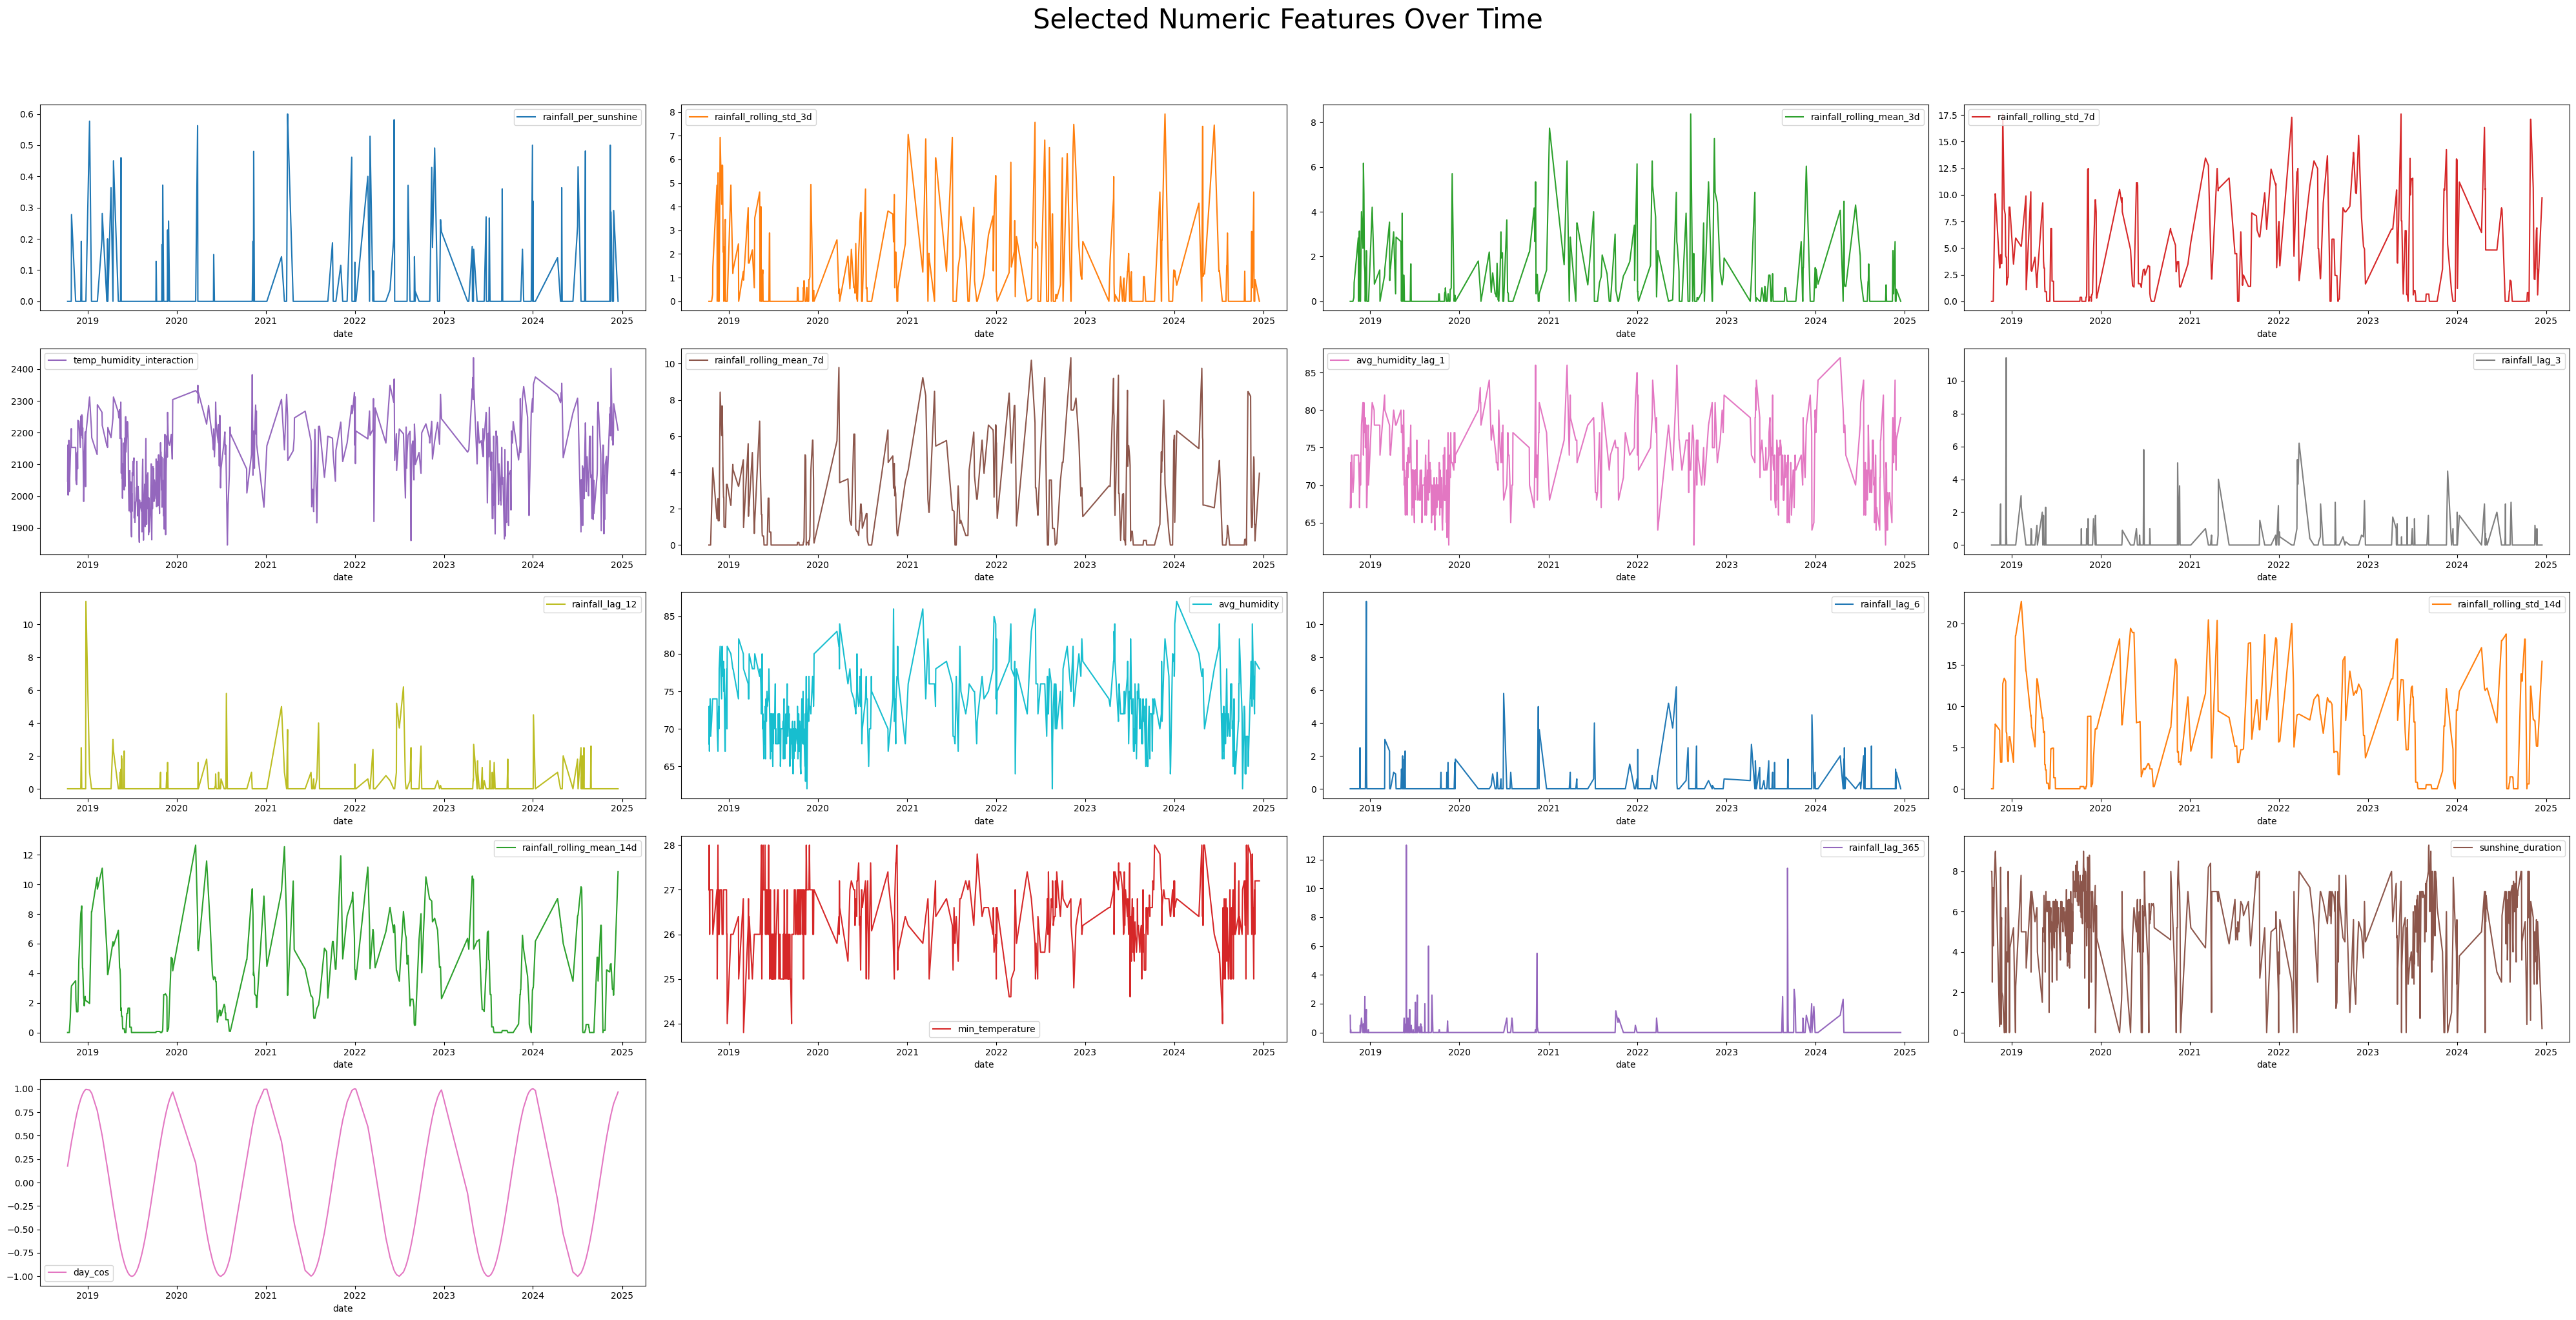

In [47]:
import matplotlib.pyplot as plt

# Plot selected features over time
numeric_selected_features = X.select_dtypes(include='number').columns # Exclude boolean values because it might distort plots
X[numeric_selected_features].plot(subplots=True, layout=(5, 4), figsize=(40, 20), sharex=False)
plt.suptitle('Selected Numeric Features Over Time', y=1.02, fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# **8. Model Architecture and Training with TimeSeriesSplit CV**

In [48]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# TimeSeries CV setup
tscv = TimeSeriesSplit(n_splits=5)
rf_preds, xgb_preds, lstm_preds, y_valids = [], [], [], []
meta_features = [] # To store out-of-fold predictions for the meta-learner

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# LSTM architecture
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True, activation='relu'),
        Dropout(0.3),
        LSTM(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

In [51]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define objective functions for Bayesian Optimization
# Random Forest objective
def rf_objective(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rf_model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1
    )
    # Use negative MSE as Bayesian Optimization maximizes
    return -np.mean(cross_val_score(rf_model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1))

# XGBoost objective
def xgb_objective(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma):
    xgb_model = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        n_jobs=-1
    )
    return -np.mean(cross_val_score(xgb_model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1))

### Bayesian Optimization for Random Forest

In [52]:
from bayes_opt import BayesianOptimization

print("--- Bayesian Optimization for Random Forest ---")
rf_pbounds = {
    'n_estimators': (100, 500),
    'max_depth': (5, 25),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5)
}
rf_optimizer = BayesianOptimization(f=rf_objective, pbounds=rf_pbounds, random_state=42)
rf_optimizer.maximize(init_points=10, n_iter=25) # Increased iterations for better tuning
best_rf_params = rf_optimizer.max['params']
print(f"Best RF params: {best_rf_params}")

--- Bayesian Optimization for Random Forest ---
|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 2         | 0.4090591 | 249.81604 | 24.014286 | 7.8559515 | 3.3946339 |
| 3         | 0.3849167 | 162.40745 | 8.1198904 | 2.4646688 | 4.4647045 |
| 4         | 0.3844908 | 340.44600 | 19.161451 | 2.1646759 | 4.8796394 |
| 5         | 0.7267335 | 432.97705 | 9.2467822 | 3.4545997 | 1.7336180 |
| 6         | 0.4633888 | 221.69689 | 15.495128 | 5.4555601 | 2.1649165 |
| 7         | 0.4606085 | 344.74115 | 7.7898772 | 4.3371571 | 2.4654473 |
| 8         | 0.4115667 | 282.42799 | 20.703519 | 3.5973902 | 3.0569377 |
| 9         | 0.6989054 | 336.96582 | 5.9290082 | 6.8603588 | 1.6820964 |
| 10        | 0.3827544 | 126.02063 | 23.977710 | 9.7250562 | 4.2335893 |
| 11        | 0.4683689 | 221.84550 | 6.9534422 | 7.4738642 | 2.7606099 |
| 12        | 0.4127084 | 365.00891 | 17.387026 | 8.8646245 | 3.

### Bayesian Optimization for XGBoost

In [53]:
print("--- Bayesian Optimization for XGBoost ---")
xgb_pbounds = {
    'n_estimators': (100, 500),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.2),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 0.5)
}
xgb_optimizer = BayesianOptimization(f=xgb_objective, pbounds=xgb_pbounds, random_state=42)
xgb_optimizer.maximize(init_points=10, n_iter=25) # Increased iterations
best_xgb_params = xgb_optimizer.max['params']
print(f"Best XGBoost params: {best_xgb_params}")

--- Bayesian Optimization for XGBoost ---
|   iter    |  target   | n_esti... | max_depth | learni... | subsample | colsam... |   gamma   |
-------------------------------------------------------------------------------------------------
| 2         | 0.5454080 | 249.81604 | 14.408571 | 0.1490788 | 0.7993292 | 0.5780093 | 0.0779972 |
| 3         | 0.5527601 | 123.23344 | 13.394113 | 0.1242118 | 0.8540362 | 0.5102922 | 0.4849549 |
| 4         | 0.6890359 | 432.97705 | 5.5480693 | 0.0445467 | 0.5917022 | 0.6521211 | 0.2623782 |
| 5         | 0.7231264 | 272.77800 | 6.4947496 | 0.1262520 | 0.5697469 | 0.6460723 | 0.1831809 |
| 6         | 0.9521869 | 282.42799 | 12.422111 | 0.0479380 | 0.7571172 | 0.7962072 | 0.0232252 |
| 7         | 1.0133933 | 343.01794 | 5.0462894 | 0.0223598 | 0.9744427 | 0.9828160 | 0.4041986 |
| 8         | 0.5930919 | 221.84550 | 4.1720653 | 0.1400042 | 0.7200762 | 0.5610191 | 0.2475884 |
| 9         | 0.7482091 | 113.75540 | 13.911844 | 0.0591681 | 0.8312611 | 0.

In [54]:
# Convert best params to int where needed
best_rf_params['n_estimators'] = int(best_rf_params['n_estimators'])
best_rf_params['max_depth'] = int(best_rf_params['max_depth'])
best_rf_params['min_samples_split'] = int(best_rf_params['min_samples_split'])
best_rf_params['min_samples_leaf'] = int(best_rf_params['min_samples_leaf'])

best_xgb_params['n_estimators'] = int(best_xgb_params['n_estimators'])
best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])

print("--- Training Base Models with TimeSeriesSplit and Stacking ---")
# This loop performs cross-validated stacking
for train_idx, val_idx in tscv.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] # Use .iloc for pandas Series

    # Random Forest
    rf = RandomForestRegressor(**best_rf_params, random_state=42)
    rf.fit(X_train, y_train)
    rf_val_preds = rf.predict(X_val)
    rf_preds.append(rf_val_preds)

    # XGBoost
    xgb = XGBRegressor(**best_xgb_params, random_state=42)
    xgb.fit(X_train, y_train)
    xgb_val_preds = xgb.predict(X_val)
    xgb_preds.append(xgb_val_preds)

    # LSTM
    # Reshape for LSTM: [samples, time_steps, features]
    # Here, time_steps is 1 as we are predicting current rainfall from current features + lags
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    lstm = create_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
    lstm.fit(X_train_lstm, y_train,
             epochs=50, batch_size=32, verbose=0,
             validation_data=(X_val_lstm, y_val),
             callbacks=[early_stopping, lr_scheduler]) # Added callbacks
    lstm_val_preds = lstm.predict(X_val_lstm).flatten()
    lstm_preds.append(lstm_val_preds)

    # Store out-of-fold predictions for meta-learner training
    # Stack predictions horizontally for the meta-learner
    fold_meta_features = np.column_stack((rf_val_preds, xgb_val_preds, lstm_val_preds))
    meta_features.append(fold_meta_features)

    y_valids.append(y_val) # Store corresponding true values

# Concatenate all out-of-fold predictions and true values
stacked_X = np.vstack(meta_features)
y_true_stacked = np.concatenate(y_valids)

--- Training Base Models with TimeSeriesSplit and Stacking ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


# **9. Stacking Layer (Meta-model)**

In [55]:
from sklearn.linear_model import LinearRegression

print("--- Training Meta-Model (Linear Regression) ---")
meta_model = LinearRegression()
meta_model.fit(stacked_X, y_true_stacked)

--- Training Meta-Model (Linear Regression) ---


LinearRegression()

# **10. Final Predictions on the Entire Dataset**

In [56]:
# Re-train base models on full X_scaled for final predictions
final_rf = RandomForestRegressor(**best_rf_params, random_state=42)
final_rf.fit(X_scaled, y)

final_xgb = XGBRegressor(**best_xgb_params, random_state=42)
final_xgb.fit(X_scaled, y)

# Reshape full data for LSTM
X_scaled_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
final_lstm = create_lstm_model(input_shape=(X_scaled_lstm.shape[1], X_scaled_lstm.shape[2]))
final_lstm.fit(X_scaled_lstm, y,
               epochs=50, batch_size=32, verbose=0,
               validation_data=(X_scaled_lstm, y), # Using full data for validation here for simplicity
               callbacks=[early_stopping, lr_scheduler])

# Get predictions from final base models
final_rf_preds = final_rf.predict(X_scaled)
final_xgb_preds = final_xgb.predict(X_scaled)
final_lstm_preds = final_lstm.predict(X_scaled_lstm).flatten()

# Stack final base predictions and get final ensemble prediction
final_stacked_X = np.column_stack((final_rf_preds, final_xgb_preds, final_lstm_preds))
final_ensemble_preds = meta_model.predict(final_stacked_X)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import seaborn as sns

def evaluate_predictions(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Check for zero true values before calculating MAPE to avoid division by zero
    # Replace zeros with a small epsilon or handle differently if many zeros are expected.
    # For now, filter out zero actuals to avoid error.
    y_true_for_mape = y_true[y_true != 0]
    y_pred_for_mape = y_pred[y_true != 0]
    mape = np.nan # Initialize as NaN
    if len(y_true_for_mape) > 0:
        mape = np.mean(np.abs((y_true_for_mape - y_pred_for_mape) / y_true_for_mape)) * 100 # MAPE in percentage
    else:
        print(f"Warning: Cannot calculate MAPE for {model_name} as all actual values are zero.")


    print(f"\n{model_name} Performance Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    if not np.isnan(mape):
        print(f"  MAPE: {mape:.2f}%")
    else:
        print(f"  MAPE: Not applicable (due to zero actuals)")

    # Visualization
    plt.figure(figsize=(18, 6))

    # Actual vs Predicted Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Rainfall (mm)', fontsize=12)
    plt.ylabel('Predicted Rainfall (mm)', fontsize=12)
    plt.title(f'{model_name}: Actual vs Predicted Rainfall', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box') # Keep aspect ratio square

    # Residuals Distribution Plot
    plt.subplot(1, 2, 2)
    residuals = y_pred - y_true
    sns.histplot(residuals, kde=True, color='purple', bins=30, edgecolor='black')
    plt.xlabel('Residuals (Predicted - Actual)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{model_name}: Residuals Distribution', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

--- Ensemble Model Final Performance Metrics (on entire dataset) ---



Final Ensemble Model Performance Metrics:
  RMSE: 0.1444
  MAE: 0.0460
  R²: 0.9755
  MAPE: 21.49%


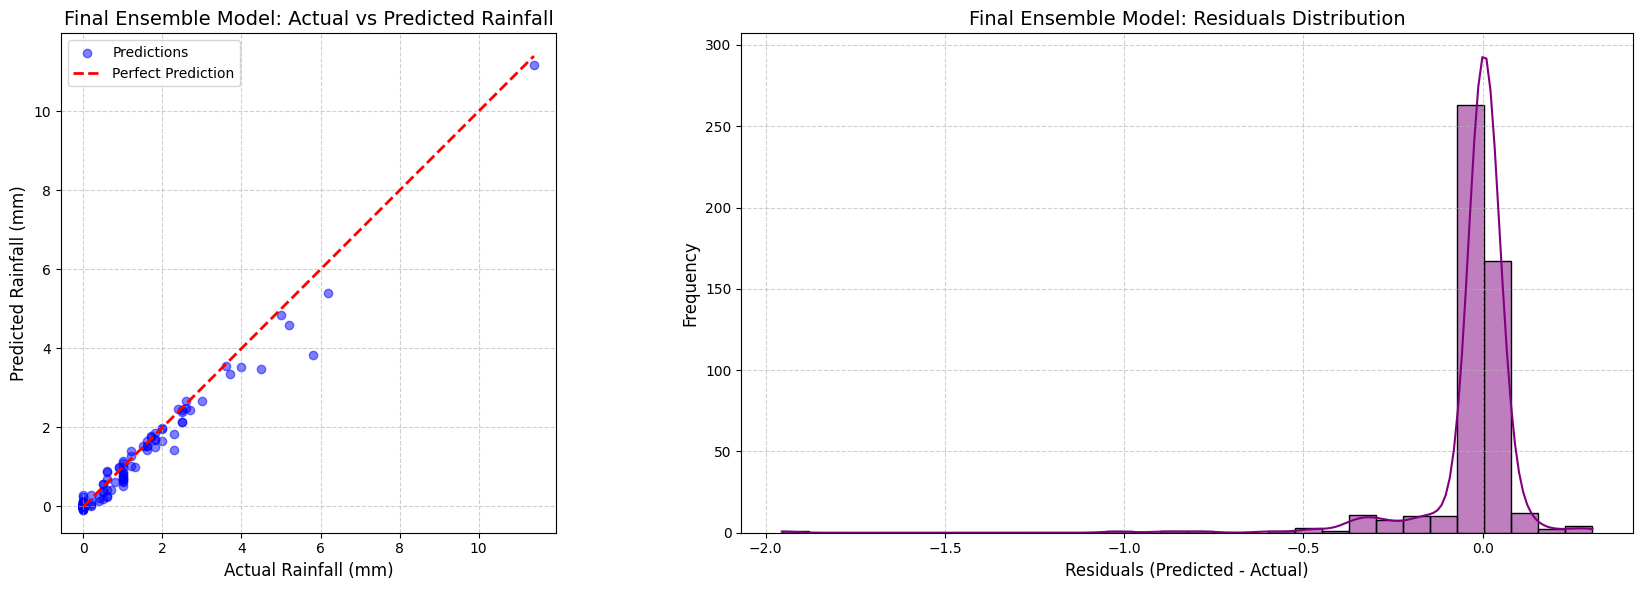


--- Standalone Models Performance Metrics (on out-of-fold predictions) ---

Random Forest Standalone Performance Metrics:
  RMSE: 0.8593
  MAE: 0.2338
  R²: -0.1473
  MAPE: 90.47%


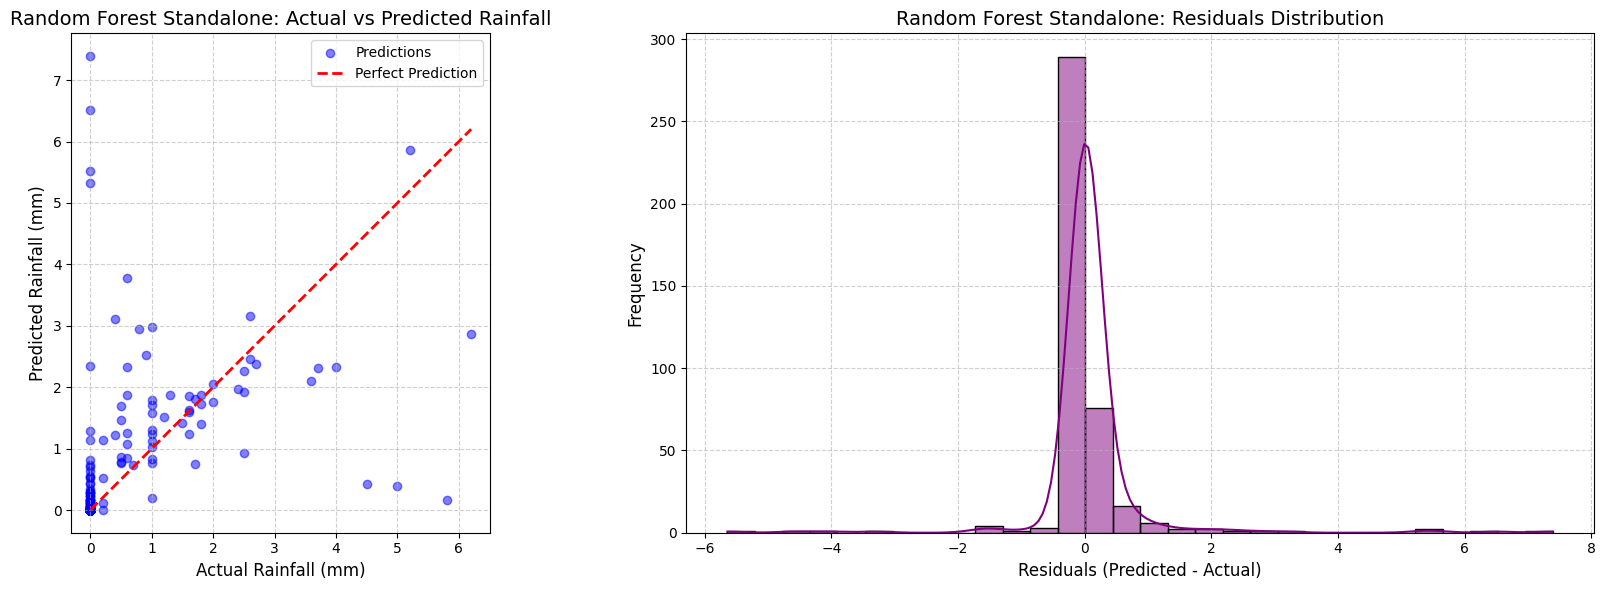


XGBoost Standalone Performance Metrics:
  RMSE: 1.0718
  MAE: 0.2459
  R²: -0.7851
  MAPE: 89.64%


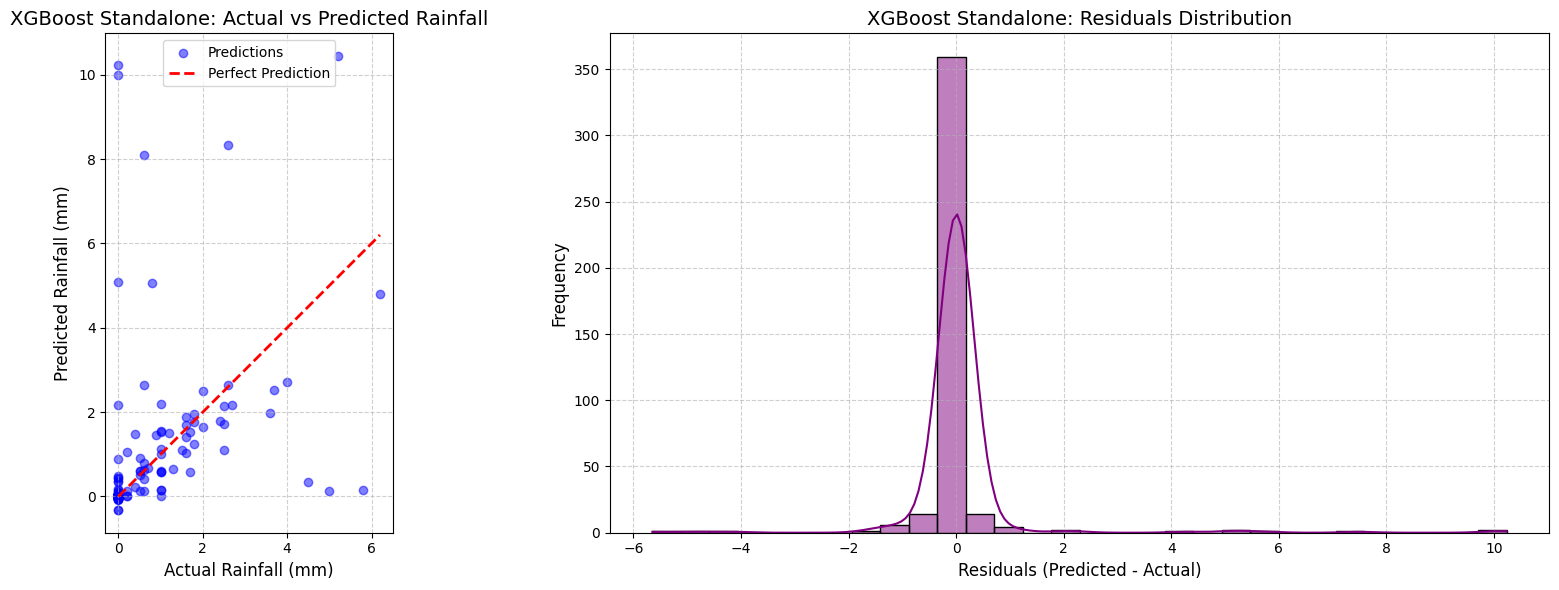


LSTM Standalone Performance Metrics:
  RMSE: 0.6606
  MAE: 0.2588
  R²: 0.3219
  MAPE: 73.80%


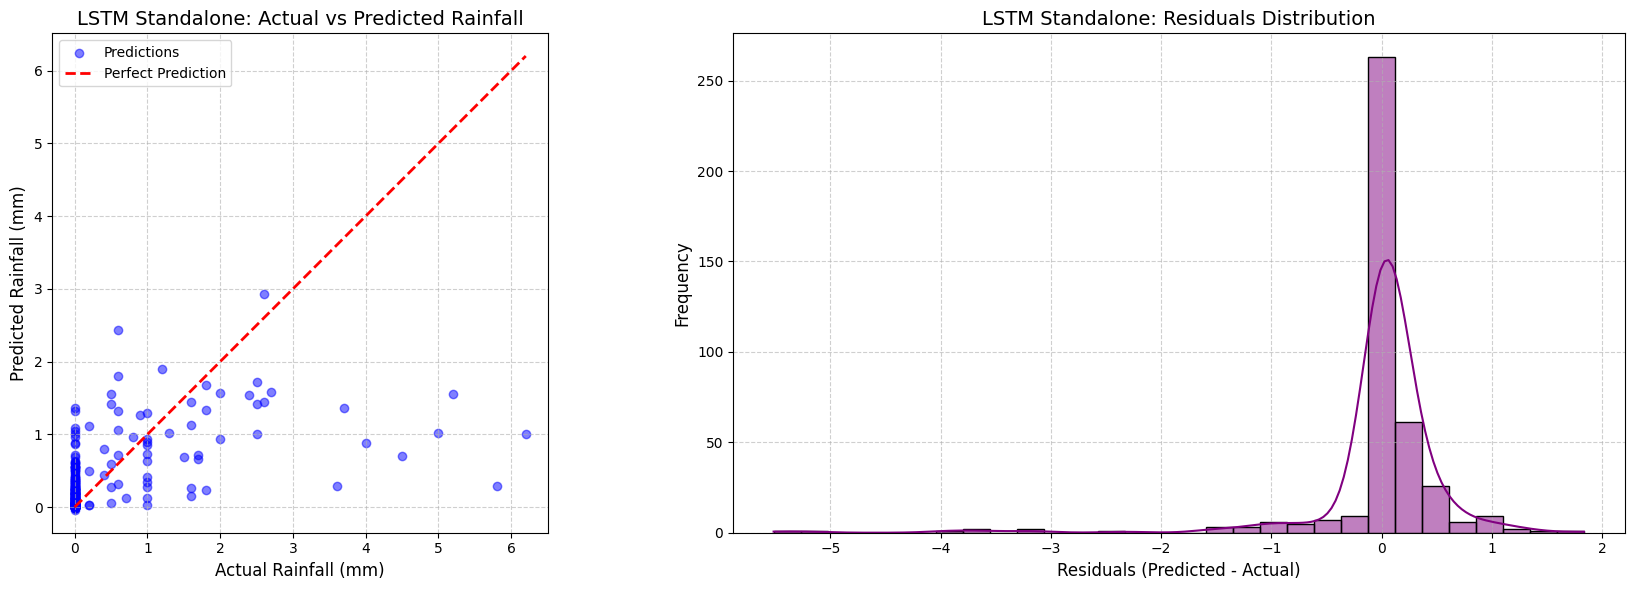

In [58]:
# Evaluate the final ensemble model on the entire dataset
print("--- Ensemble Model Final Performance Metrics (on entire dataset) ---")
evaluate_predictions(y, final_ensemble_preds, "Final Ensemble Model")

# --- Evaluate Standalone Models for comparison ---
print("\n--- Standalone Models Performance Metrics (on out-of-fold predictions) ---")

# Evaluate individual RF model performance from CV folds
rf_oof_preds = np.concatenate(rf_preds)
evaluate_predictions(y_true_stacked, rf_oof_preds, "Random Forest Standalone")

# Evaluate individual XGBoost model performance from CV folds
xgb_oof_preds = np.concatenate(xgb_preds)
evaluate_predictions(y_true_stacked, xgb_oof_preds, "XGBoost Standalone")

# Evaluate individual LSTM model performance from CV folds
lstm_oof_preds = np.concatenate(lstm_preds)
evaluate_predictions(y_true_stacked, lstm_oof_preds, "LSTM Standalone")

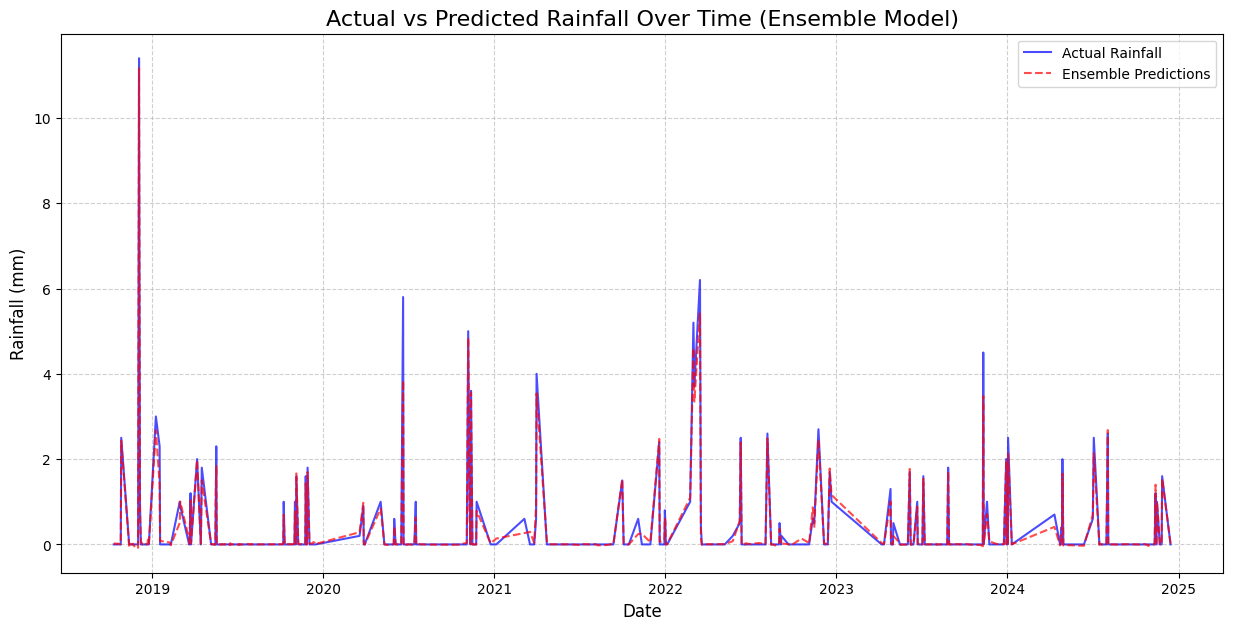

In [59]:
# Make a line chart to visualize the prediction result with the actual dataset
plt.figure(figsize=(15, 7))
plt.plot(y.index, y, label='Actual Rainfall', color='blue', alpha=0.7)
plt.plot(y.index, final_ensemble_preds, label='Ensemble Predictions', color='red', linestyle='--', alpha=0.7)
# You can add other model predictions here for comparison if desired
# plt.plot(y.index, final_rf_preds, label='RF Predictions', color='green', linestyle=':', alpha=0.5)
# plt.plot(y.index, final_xgb_preds, label='XGB Predictions', color='purple', linestyle=':', alpha=0.5)
# plt.plot(y.index, final_lstm_preds, label='LSTM Predictions', color='orange', linestyle=':', alpha=0.5)

plt.title('Actual vs Predicted Rainfall Over Time (Ensemble Model)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rainfall (mm)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# **11. Advanced Evaluation Metrics and Visualization**

--- SHAP Explainability for XGBoost ---


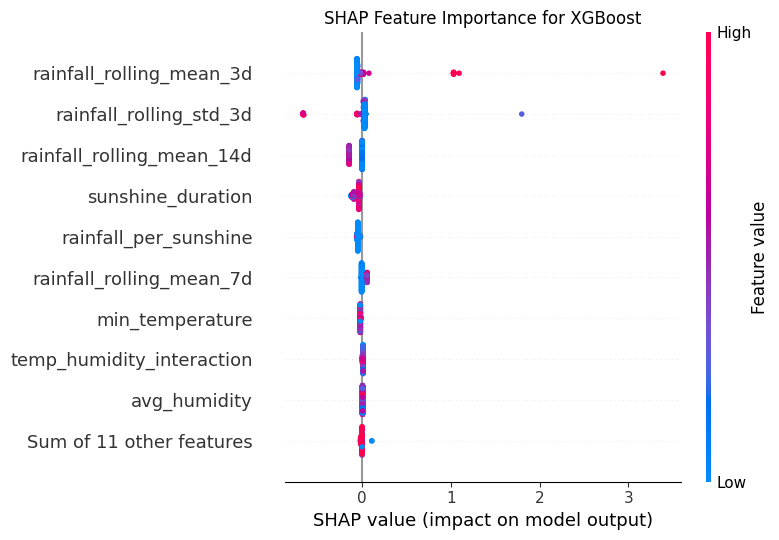

In [60]:
import shap

print("--- SHAP Explainability for XGBoost ---")
try:
    explainer = shap.TreeExplainer(final_xgb)
    # Using a subset for SHAP to avoid very long computation if X is very large
    sample_X = X.sample(n=min(200, len(X)), random_state=42)
    shap_values = explainer.shap_values(sample_X)

    # Create a shap.Explanation object for plotting
    shap_explanation = shap.Explanation(
        values=shap_values,
        base_values=explainer.expected_value,
        data=sample_X.values,
        feature_names=X.columns.tolist() # Use the column names from the DataFrame X
    )

    shap.plots.beeswarm(shap_explanation, max_display=10, show=False)
    plt.title("SHAP Feature Importance for XGBoost")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"SHAP plotting failed: {e}. Ensure XGBoost model is tree-based and SHAP package is compatible.")

In [61]:
# import joblib

# --- 13. Save Models for Reproducibility ---
# print("\n--- Saving Models ---")
# try:
#     joblib.dump(final_rf, 'rf_model_final.pkl')
#     joblib.dump(final_xgb, 'xgb_model_final.pkl')
#     final_lstm.save('lstm_model_final.h5') # Keras models are saved differently
#     joblib.dump(meta_model, 'meta_model_final.pkl')
#     joblib.dump(scaler, 'scaler_final.pkl')
#     print("All models and scaler saved successfully.")
# except Exception as e:
#     print(f"Error saving models: {e}")